# Brain Tumor MRI Classification – LSTM

This notebook trains a **Long Short-Term Memory (LSTM)** on the Brain Tumor MRI Dataset – Merged (4 classes).
- Shared preprocessing: grayscale, resize to 64×64, normalize
- Train/val split with stratification
- Metrics: Accuracy, F1-score, Confusion Matrix; plus learning curves

> Set `DATA_DIR` to your dataset root (with subfolders: `glioma/`, `meningioma/`, `pituitary/`, `no_tumor/`).

TensorFlow: 2.20.0
Found 13351 images across 4 classes.
Train: 10680  Val: 2671


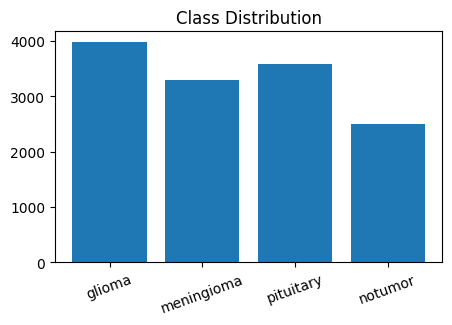

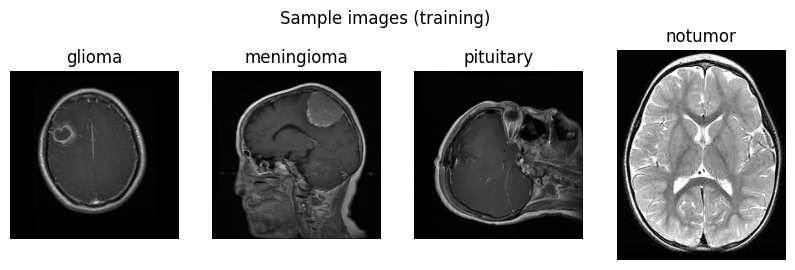

In [3]:
# --- Setup & Imports (TensorFlow/Keras) ---
import os, pathlib, random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

print("TensorFlow:", tf.__version__)
DATA_DIR = "../data"  # <-- change if needed
IMG_SIZE = (64, 64)
BATCH_SIZE = 32
SEED = 42

# --- Load image paths and labels from folder structure ---
data_root = pathlib.Path(DATA_DIR)
classes = ["glioma", "meningioma", "pituitary", "notumor"]
class_to_idx = {c:i for i,c in enumerate(classes)}

image_paths, labels = [], []
for c in classes:
    class_dir = data_root / c
    if not class_dir.exists():
        raise FileNotFoundError(f"Missing folder: {class_dir}. Create subfolders for each class and add images.")
    for p in class_dir.glob("*"):
        if p.suffix.lower() in {".jpg",".jpeg",".png",".bmp"}:
            image_paths.append(str(p))
            labels.append(class_to_idx[c])

print(f"Found {len(image_paths)} images across {len(classes)} classes.")

# Stratified split
X_train, X_val, y_train, y_val = train_test_split(
    image_paths, labels, test_size=0.2, random_state=SEED, stratify=labels
)
print("Train:", len(X_train), " Val:", len(X_val))

# Class distribution
from collections import Counter
cnt = Counter(labels)
plt.figure(figsize=(5,3))
plt.bar(cnt.keys(), cnt.values())
plt.xticks(range(len(classes)), classes, rotation=20)
plt.title("Class Distribution")
plt.show()

# Show a sample from each class
plt.figure(figsize=(10,3))
for i, c in enumerate(classes):
    try:
        idx = next(k for k, lab in enumerate(y_train) if lab == class_to_idx[c])
        img = plt.imread(X_train[idx])
        if img.ndim == 3:
            img = img[...,0]  # view as grayscale for display
        plt.subplot(1,4,i+1); plt.imshow(img, cmap="gray"); plt.title(c); plt.axis("off")
    except StopIteration:
        pass
plt.suptitle("Sample images (training)"); plt.show()

# --- TF data pipeline ---
AUTOTUNE = tf.data.AUTOTUNE

def load_img(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=1)
    img.set_shape([None, None, 1])  # Set shape explicitly
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32)/255.0
    return img, tf.cast(label, tf.int32)

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train), seed=SEED)
train_ds = train_ds.map(load_img, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = val_ds.map(load_img, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [4]:
# Data augmentation (applied during training only)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
], name="augmentation")

In [5]:
# --- LSTM model ---
inputs = layers.Input(shape=(*IMG_SIZE, 1))
x = data_augmentation(inputs)
x = layers.Reshape((IMG_SIZE[0], IMG_SIZE[1]))(x)  # (64 timesteps, 64 features)
x = layers.LSTM(128, return_sequences=True)(x)
x = layers.LSTM(64)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(32, activation="relu")(x)
outputs = layers.Dense(4, activation="softmax")(x)
model = models.Model(inputs, outputs)
model.compile(optimizer=optimizers.Adam(1e-3),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 64, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 150,436 (587.64 KB)

 Trainable params: 150,436 (587.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/12
334/334 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.4495 - loss: 1.2088 - val_accuracy: 0.5227 - val_loss: 1.0563
Epoch 2/12
334/334 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.4495 - loss: 1.2088 - val_accuracy: 0.5227 - val_loss: 1.0563
Epoch 2/12
334/334 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.5221 - loss: 1.0869 - val_accuracy: 0.5653 - val_loss: 1.0074
Epoch 3/12
334/334 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.5221 - loss: 1.0869 - val_accuracy: 0.5653 - val_loss: 1.0074
Epoch 3/12
334/334 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.5506 - loss: 1.0413 - val_accuracy: 0.6155 - val_loss: 0.9204
Epoch 4/12
334/334 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.5506 - loss: 1.0413 - val_accuracy: 0.6155 - val_loss: 0.9204
Epoch 4/12
334/334 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - accuracy: 0.5766 - loss: 1.0027 - val_accuracy: 0.5545 - val_loss: 0.9654
Epoch 5/12
334/334 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - accuracy: 0.5766 - loss: 1.0027 - 

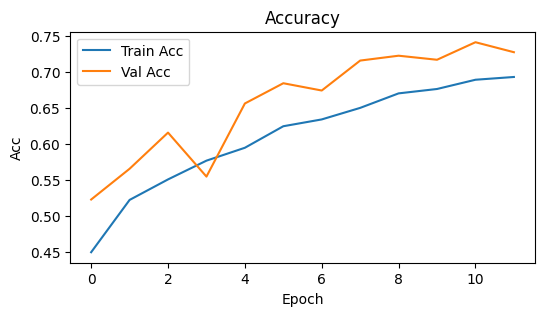

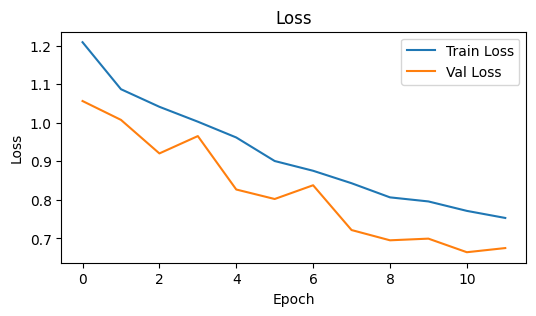

84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step


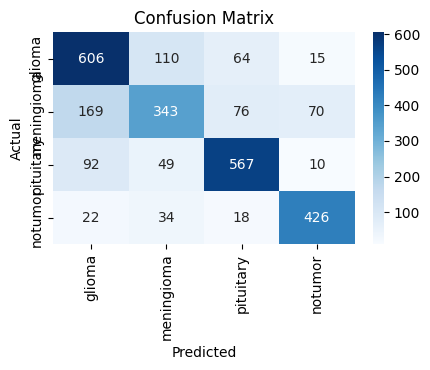

              precision    recall  f1-score   support

      glioma       0.68      0.76      0.72       795
  meningioma       0.64      0.52      0.57       658
   pituitary       0.78      0.79      0.79       718
     notumor       0.82      0.85      0.83       500

    accuracy                           0.73      2671
   macro avg       0.73      0.73      0.73      2671
weighted avg       0.72      0.73      0.72      2671

Weighted F1: 0.723215192832444


In [6]:
# --- Train ---
EPOCHS = 12
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

# --- Learning curves ---
plt.figure(figsize=(6,3)); 
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.title("Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Acc"); plt.legend(); plt.show()

plt.figure(figsize=(6,3)); 
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()

# --- Evaluation ---
y_true = np.array(y_val)
y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(4.5,3.8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix"); plt.ylabel("Actual"); plt.xlabel("Predicted"); plt.tight_layout(); plt.show()

print(classification_report(y_true, y_pred, target_names=classes))
print("Weighted F1:", f1_score(y_true, y_pred, average="weighted"))